In [3]:
from data import Data
import numpy as np
import matplotlib.pyplot as plt
# Set up our data management object
d = Data()

In [4]:
# Collect the data from each of the sources
sparcGalaxies = d.getGalaxyData("data/Sparc/Rotmod_LTG/")
xueSofueGalaxies = d.getGalaxyData("data/XueSofue/")

In [5]:
# Get the galaxies we want from each source
NGC5371 = np.array(sparcGalaxies['NGC5371_rotmod'])
MWXueSofue = np.array(xueSofueGalaxies['MW_lum'])

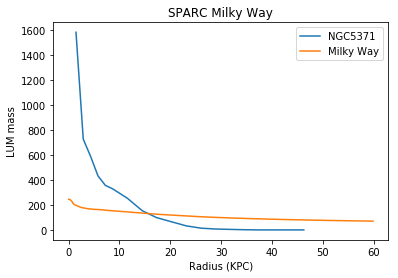

In [6]:
# Plot both galaxies side by side
kpc_NGC5371 = NGC5371[:,0]
vobs_NGC5371 = NGC5371[:,6]
kpc_MW = MWXueSofue[:,0]
vobs_MW = MWXueSofue[:,1]
plt.plot(kpc_NGC5371, vobs_NGC5371, kpc_MW, vobs_MW)
plt.legend(['NGC5371', 'Milky Way', 'cubic'], loc='best')
plt.xlabel('Radius (KPC)')
plt.ylabel('LUM mass')
plt.title('SPARC Milky Way')
plt.show()